<a href="https://colab.research.google.com/github/pavelperc/kaggle_copy/blob/master/kaaagle_shared_in_drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Надо подружить колаб с папкой на гугл-диске!
from google.colab import drive
drive.mount('/content/drive')
path = "./drive/My Drive/kaggle/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer, TfidfVectorizer
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier


pd.options.mode.chained_assignment = None
%matplotlib inline
random_state = 42

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [1]:
print('mya')
print('mya')
print('mya')

mya
mya
mya


In [0]:
print('teeeeeest')

teeeeeest


# Data Loading

In [0]:
df = pd.read_csv(path+'train.tsv.gz', sep='\t', index_col=0)
df_test = pd.read_csv(path+'test_nolabel.tsv.gz', sep='\t', index_col=0)

In [0]:
# Set types of columns
df.delivery_available = df.delivery_available.astype('int')
df.payment_available = df.payment_available.astype('int')
df.date_created = pd.to_datetime(df.date_created)

pd.set_option('display.max_colwidth', 500)
df.head(10)

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
1,4,Краснодар,2018-10-08,0,"Продаю стол раскладной, деревянный, советский на века. Состояние осень хорошее. Торг уместен. Самовывоз ФМР",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,1,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': 'Тип', 'value': 'Столы', 'value_id': 9490}]",Краснодарский край,1,410,1
2,4,Тюмень,2018-06-18,0,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. Все ранешний фарфор. В другом пакете современные блюдца, чашки и чайник с мишкой Тедди. Ничем практически не пользовались",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,0,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_name': 'Тип', 'value': 'Тарелки', 'value_id': 9461}]",Тюменская область,1,405,0
4,9,Омск,2018-07-31,1,"Новый,с этикеткой. Размер L. Не подошёл по размеру,маломерит на размер. Померить можно ул. 25 Линия 74. В любое удобное для вас время.",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,1,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,"[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kostyumy_tip', 'slug_name': 'Тип', 'value': 'Костюмы с юбкой', 'value_id': 8362}, {'slug_id': 'zhenskaya_odezhda_razmer', 'slug_name': 'Размер', 'value': '46-48 (L)', 'value_id': 8290}]",Омская область,1,908,0
6,3,Санкт-Петербург,2018-04-17,0,"Складывается тростью, все колеса вниз. Сплошная ручка, сама стоит в сложенном виде, капюшон закрывает до бампера, передние колеса одинарные, по снегу и каше едут. Это аналог пег перего си, только со сплошной ручкой. в БЕЗУПРЕЧНом состоянии (покупалась только чтоб на подготовку к школе старшего водить, зимой ездить, Макларен перестал по снегу из- за сдвоенных колес, буксовал и надо было собирать компактно в машину коляску из сада до школы ехать. 2 раза в неделю использовали по 2 часа)",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,1,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип', 'value': 'Прогулочная', 'value_id': 8615}, {'slug_id': 'waggon_max_age', 'slug_name': 'Возраст', 'value': 'До 3 лет', 'value_id': 8620}]",Ленинградская область,1,312,0
10,5,Москва,2018-02-09,0,"Неразлучники, птичкам по 1,5 года. Продаю с большой клеткой, кормушками и поилкой",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,1,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0
11,11,Гусь-Хрустальный,2018-04-28,0,"Продам детский велосипед,двухколесный,лет для 5-6ти. Маленьких боковых колес нет.",1,55.6063,40.6564,Велосипед детский,9ba6bb7a01bf0e577a36682da64a5dde,1,800.0,c73fd3f12f71c73ad4fa9c1b4b4f3629,1,"[{'slug_id': 'sport_tzvet', 'slug_name': 'Цвет', 'value': 'Зеленый', 'value_id': 10188}, {'slug_id': 'velosipedy_tip', 'slug_name': 'Тип', 'value': 'Городские, дорожные', 'value_id': 10173}]",Владимирская область,1,1107,0
12,5,Якутск,2018-02-08,0,"Отдам кота, 8 месяцев, к горшку приучен.",1,62.0355,129.6755,скоттиш страйт,7e0e13efb64cfbb1daf62a87ed63bf1f,0,1.0,be19161f29cc7e6e1795f756ef9e29e0,1,"[{'slug_id': 'koshki_poroda', 'slug_name': 'Порода', 'value': 'Шотландская', 'value_id': 10437}]",Республика Саха (Якутия),1,503,0
13,13,Краснодар,2018-10-14,0,ТВ в рабочем состоянии,3,45.0618,38.9170,LE32R72B,e8e578f2dd291cc1b2e5944cb869028a,0,6000.0,c76ee67dfc81c0f06a3d908370a2f59e,1,"[{'slug_id': 'televizory_marka', 'slug_name': 'Марка', 'value': 'Samsung', 'value_id': 9612}, {'slug_id': 'televizory_tip', 'slug_name': 'Тип', 'value': 'ЖК, LED', 'value_id': 9588}, {'slug_id': 'televizory_diagonal_ekrana', 'slug_name': 'Диагональ экрана', 'value': 'От 30"" до 34.9""', 'value_id': 9625}]",Краснодарский край,1,1302,0
14,25,Орск,2018-06-02,0,1991 г.в.Пробег около 20000 км. Документы есть. Полностью на ходу.,2,51.2585,58.6035,Минск,a992d673ee26064a0e9d157296244739,0,15000.0,c19620

In [0]:
len(df),len(df_test)

(351281, 89251)

In [0]:
df.properties[1]

"[{'slug_id': 'stoly_stulya_tip', 'slug_name': 'Тип', 'value': 'Столы', 'value_id': 9490}]"

In [0]:
df.sort_values(by='date_created').head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
221737,12,Архангельск,2018-01-01,1,"iPhone 5 c желтого цвета в отличном состоянии,...",2,64.5389,40.5404,iPhone 5 c,0c98f60d0b5e22fac72460479ab2ef51,1,5500.0,60a814a6806be7fb22b89a52f789b91f,1,"[{'slug_id': 'phone_brand', 'slug_name': 'Марк...",Архангельская область,1,1202,1
380921,12,Химки,2018-01-01,1,"Процессор: 1300 Мгц (4-ядерный), граф.процессо...",4,55.8786,37.4247,Смартфон Alcatel 7041d,2ac5c9ad2db6f768866617027c1c7872,1,1500.0,2b63b6e7801993186e12c98481bec1fc,1,[{'slug_id': 'smartfony_slot_dlya_karty_pamyat...,Московская область,1,1202,1
202514,2,Новокузнецк,2018-01-01,0,"Стиралка и центрифуга ФЕЯ. НА ДАЧУ, ВСЁ В РАБО...",3,53.8346,87.1962,ФЕЯ - 2,2cf71c0e569fbc2c8e27baf355119980,0,1000.0,f7cba720bb7c713f3356f85410b75ccf,1,[],Кемеровская область,1,208,0
261414,15,Нижний Тагил,2018-01-01,0,Видеокарта на 1 GB В отличном состоянии,1,57.9136,59.9734,Geforce 210 1gb,adf8a79665003f75c58c0d9da120488b,1,1000.0,db0676571b71324354300c26aed4874a,1,[{'slug_id': 'kompjuteri_komplektuyushchie_ust...,Свердловская область,1,1508,1
368416,15,Москва,2018-01-01,0,Мать: Asus P8H77-M PRO Процессор: Intel Core i...,1,55.8584,37.5033,Системный блок,39d6d4a848aca2408c364336d2cf22e7,1,20000.0,0f5ed5c414e39cf99ea276d4d0289ecb,1,"[{'slug_id': 'kompyutery_tip', 'slug_name': 'Т...",Московская область,1,1502,0


# Descriptive Data Analysis

* Analyze train dataset features
    * Provide some meaningfull description about corresponding features (in form of pictures or some coefficients)
    * Outline any findings you are able to reveal
* Try to measure analyse any correspondense between features and target features

In [0]:
# Соотношение числа представителей классов
counts = df.sold_fast.value_counts()
counts, counts[1]/counts[0] # 

(0    270201
 1     81080
 Name: sold_fast, dtype: int64, 0.30007290868649633)

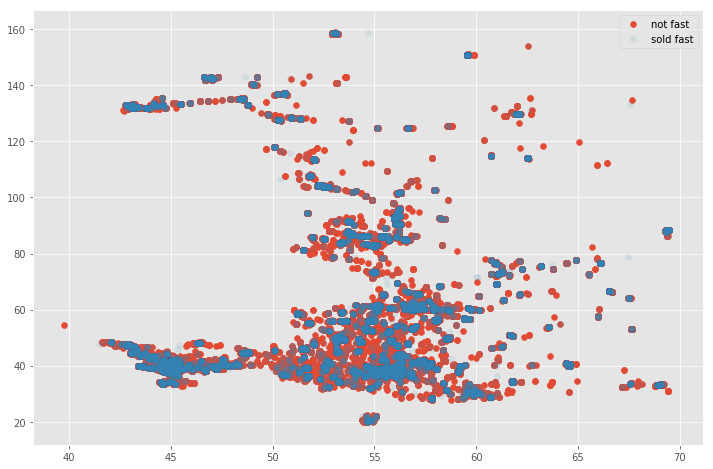

In [0]:
# Геопозиция и скорость продаж - не похоже что сильно связаны
df0 = df[df.sold_fast == 0]
df1 = df[df.sold_fast == 1]
plt.scatter(x='lat', y='long', data=df0,alpha=1,label='not fast') 
plt.scatter(x='lat', y='long', data=df1,alpha=0.1,label='sold fast') 
plt.legend()

Посмотрим на все числовые фичи - хорошо коррелируют payment_available, delivery_available и product_type c img_num, цена с product_type, img_num, payment_available

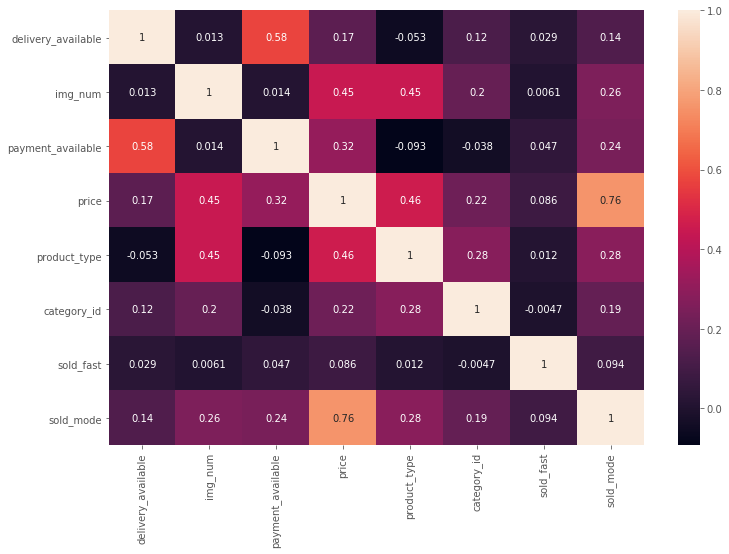

In [0]:
df2 = df[['delivery_available','img_num','payment_available','price','product_type','category_id','sold_fast','sold_mode']]
df2.loc[df2.price== 0,:] = 0.0001
df2.loc[:,'price'] = np.log10(df2.loc[:,'price'])
sns.heatmap(df2.corr(),annot=True)

Цена и скорость продажи - при высокой цене продукты не очень быстро продаются, но в среднем не очень связаны

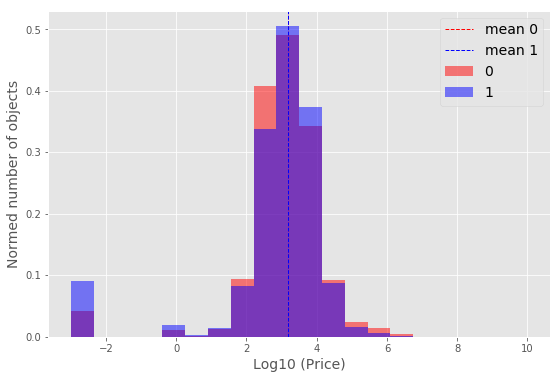

In [0]:
df.loc[df.price== 0,'price'] = 0.001
feature_values = np.log10(df.price.values)
labels = df.sold_fast.values
feature_values_notnull = feature_values[feature_values!=-3]
labels_notnull = labels[feature_values!=-3]

plt.figure(figsize=(9, 6))
bins = np.linspace(-3, 10, 21)

plt.hist(feature_values[labels == 0], bins=bins, label='0', color='r', alpha=0.5, density=True)
plt.hist(feature_values[labels == 1], bins=bins, label='1', color='b', alpha=0.5, density=True)
plt.axvline(feature_values_notnull[labels_notnull == 1].mean(), color='r', linestyle='dashed', linewidth=1,label='mean 0')
plt.axvline(feature_values_notnull[labels_notnull == 0].mean(), color='b', linestyle='dashed', linewidth=1,label='mean 1')

plt.ylabel('Normed number of objects', size=14)
plt.xlabel('Log10 (Price)', size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

In [0]:
df.city.value_counts().head()

Москва             46973
Санкт-Петербург    20962
Екатеринбург       10833
Новосибирск        10136
Краснодар           8703
Name: city, dtype: int64

In [0]:
# save cities
cities = df.city.unique()
#np.savetxt('cities.txt', cities,'%s') 

# load translated city names(by Yandex-translate:)
translated = pd.read_table('../input/translated_cities.txt',header=None)
translated.columns = ['city_en']
city = pd.concat([translated, pd.Series(cities,name='city')],axis=1)
city.head()

,city_en,city
0,Krasnodar,Краснодар
1,Tyumen,Тюмень
2,Omsk,Омск
3,Saint-Petersburg,Санкт-Петербург
4,Moscow,Москва


In [0]:
#  я хотела считать расстояние до центра города и nominatim как раз умеет возвращать координаты 
# по названию города, но он отказывается со мной сотрудничать, т.к. у меня слишком много запросов((
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# получаем координаты
#geolocator = Nominatim()
#location = geolocator.geocode("Omsk")
#pos = (location.latitude, location.longitude)
#print(location, pos)
# cчитаем расстояние
#place = df[df.city == 'Омск'].iloc[121]
#distance = geodesic(pos,(place.lat, place.long))
#print(distance.km)

def get_location(name):
    geolocator = Nominatim()
    location = geolocator.geocode(name)
    if location is None:
        return 0
    else:
        return (location.latitude, location.longitude)
#locations = list(map(get_location,city.city_en.values))
#city.location = locations

связано ли кол-во выставляемых товаров продавцами со скоростью продаж

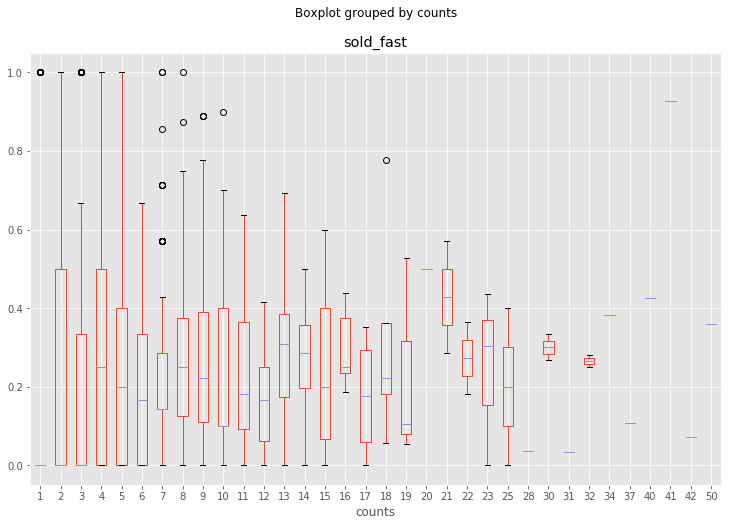

In [0]:
owners = df.groupby(by='owner_id').sold_fast.mean()
counts = df.owner_id.value_counts()
owners_counts = pd.DataFrame({'sold_fast':owners,'counts':counts}).sort_values('counts',ascending =  False)
owners_counts.boxplot('sold_fast','counts')
#owners_counts

Получим категории и субкатегории, которые быстрее всего раскупаются

Text(0.5, 1.0, 'Most popular categories')

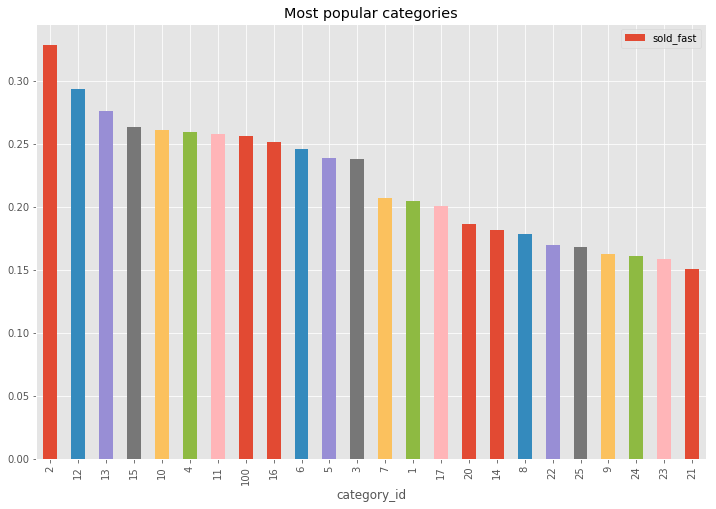

In [0]:
cat = df.groupby(by='category_id').sold_fast.mean()
cat = pd.DataFrame(cat).sort_values(by='sold_fast',ascending=False)
cat.plot.bar(y='sold_fast')
plt.title('Most popular categories')

Text(0.5, 1.0, 'Top subcategories')

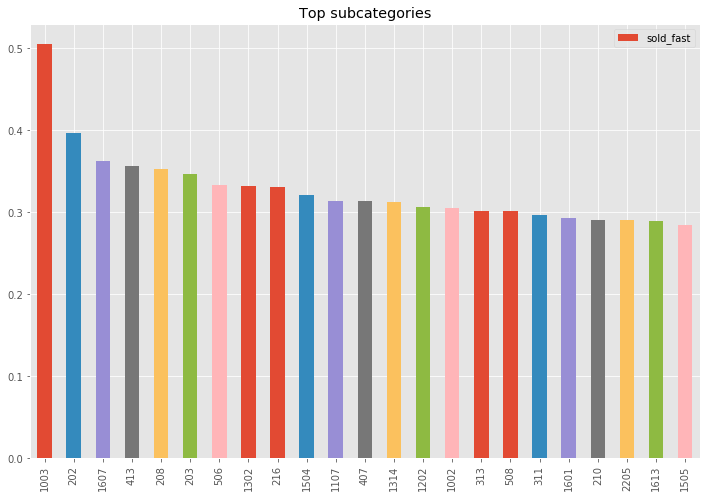

In [0]:
subcat = df.groupby(by='subcategory_id').sold_fast.mean()
counts = df.subcategory_id.value_counts()
subcat = pd.DataFrame({'sold_fast':subcat,'counts':counts})
subcat = subcat.sort_values(by=['sold_fast'],ascending=False).head(30)
subcat = subcat[subcat.counts >= 50]
subcat.plot.bar(y='sold_fast')
plt.title('Top subcategories')


Посмотрим на быстро раскупаемые товары и в каких регионах и городах они чаще

In [0]:
def get_sold_fast(feature, top = 25, min_ratio = None, dataframe = False):
    fig,ax = plt.subplots()
    
    feat = df.groupby(by=['sold_fast',feature])[feature].count()
    feat_sold_fast = feat[1]
    feat_sold_fast = pd.DataFrame({'count_sold_fast':feat_sold_fast})
    feat_sold_fast = feat_sold_fast.sort_values(by='count_sold_fast',ascending=False)
    
    
    count = df[feature].value_counts()
    count.name = 'count_all'
    feat_sold_fast = feat_sold_fast.join(count)
    feat_sold_fast.head(top).plot.bar(y='count_all',ax=ax,color='black',alpha=0.2)
    feat_sold_fast.head(top).plot.bar(y='count_sold_fast',ax=ax)
    plt.title(f'Top {feature} by number of sold_fast')
    
    #feat_sold_fast = feat_sold_fast[feat_sold_fast.count_all > 50]
    feat_sold_fast.loc[:,'ratio'] = feat_sold_fast.count_sold_fast / feat_sold_fast.count_all
    feat_sold_fast = feat_sold_fast.sort_values(by='ratio',ascending=False)
    
    if dataframe: 
        return feat_sold_fast.head(top)
    elif min_ratio is not None:
        feat_sold_fast = feat_sold_fast[feat_sold_fast.ratio>min_ratio]
        return feat_sold_fast
    else:
        feat_sold_fast = feat_sold_fast.head(top)
        feat_sold_fast.plot.bar(y='ratio')
        plt.title(f'Top {feature} by ratio sold_fast/all')
        #feat_sold_fast = feat_sold_fast.sort_values(by='counts_all',ascending=False)
        #feat_sold_fast_top_ratio.plot.bar(y='count_all')
        #plt.title(f'Top {feature} by ratio sold_fast/all - number')
        
        

In [0]:
def get_heatmap(feature):
    feat = df.groupby(by=['sold_fast',feature])[feature].count()
    sns.heatmap(feat.unstack(),annot=True,fmt='.2f',cmap='rocket_r')

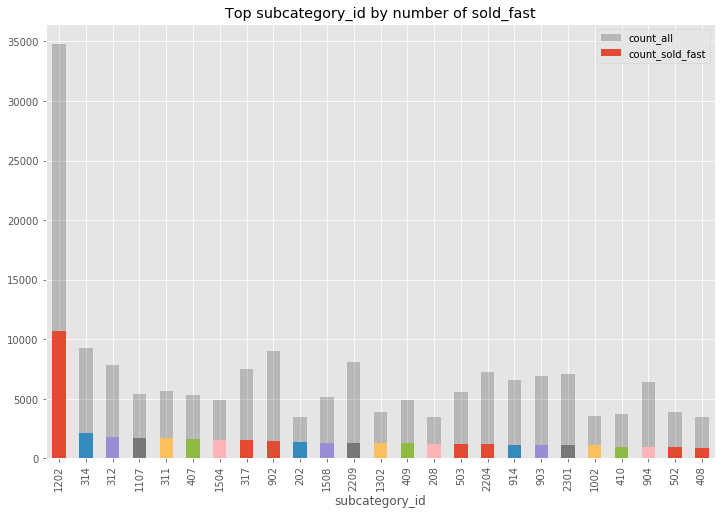

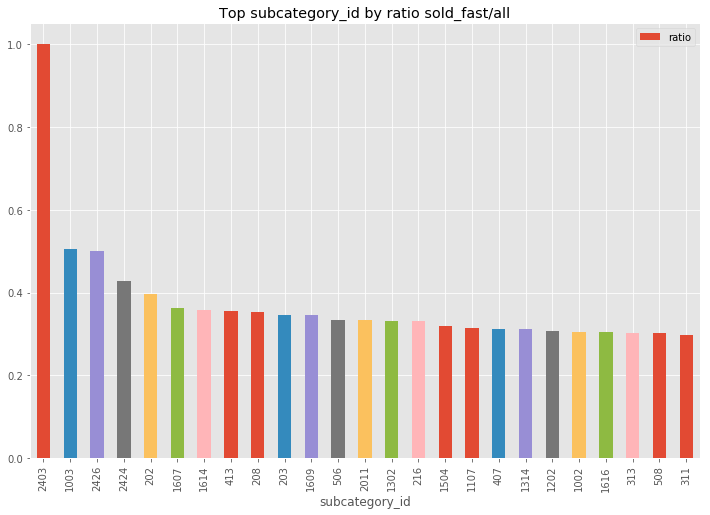

In [0]:
get_sold_fast('subcategory_id')

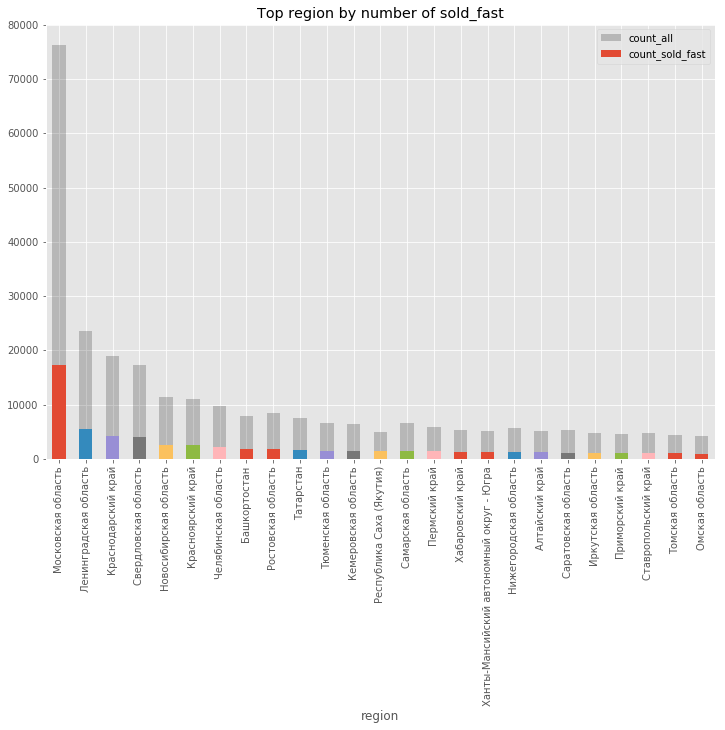

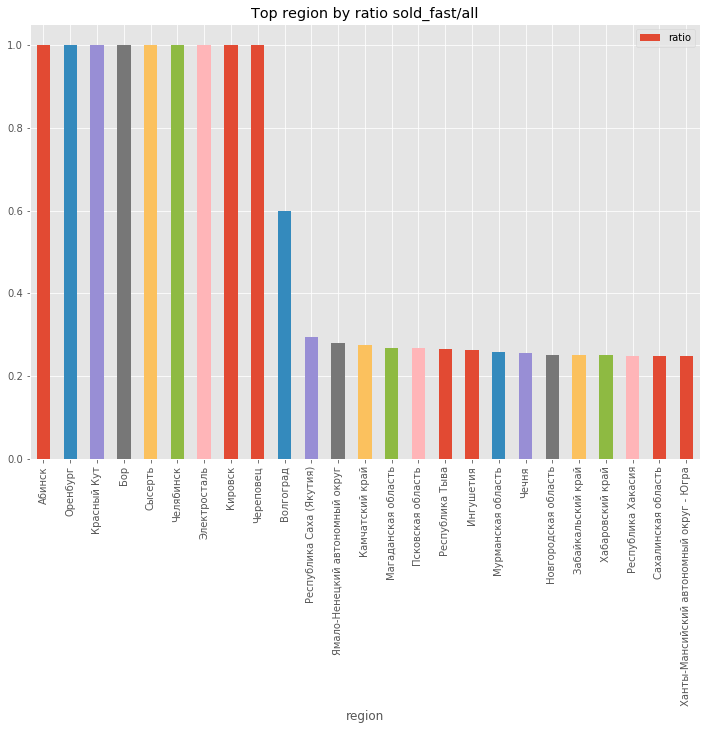

In [0]:
get_sold_fast('region')

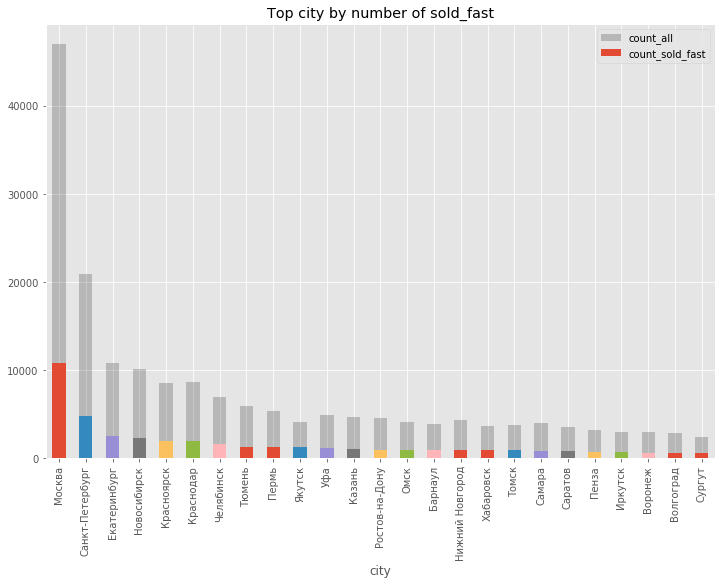

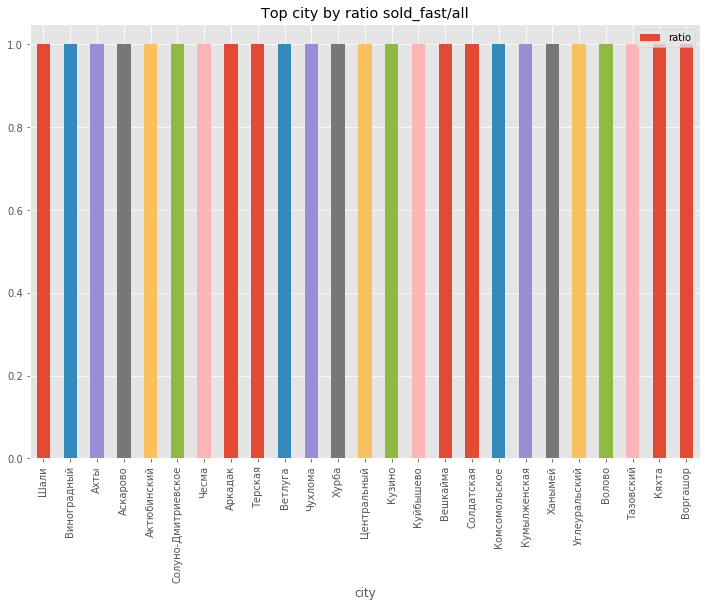

In [0]:
get_sold_fast('city')

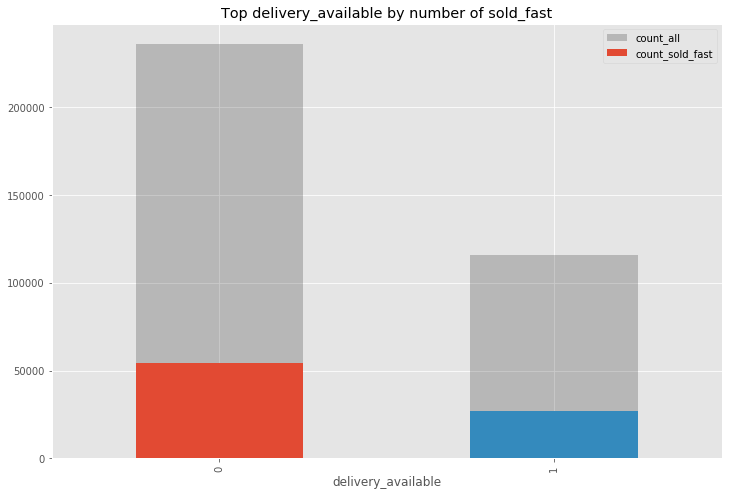

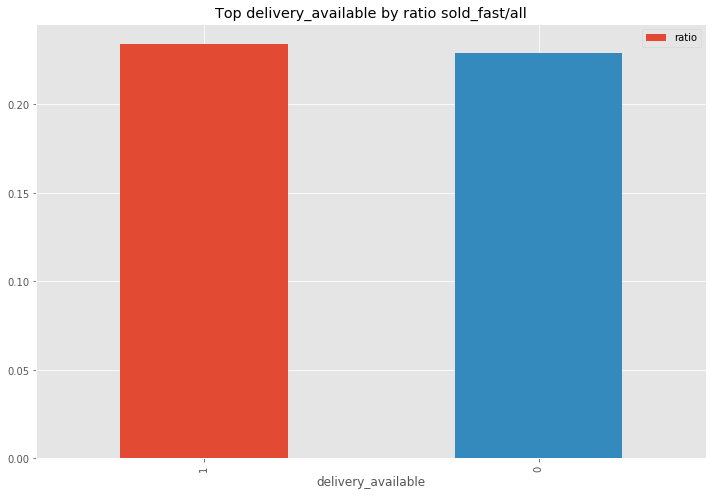

In [0]:
get_sold_fast('delivery_available')

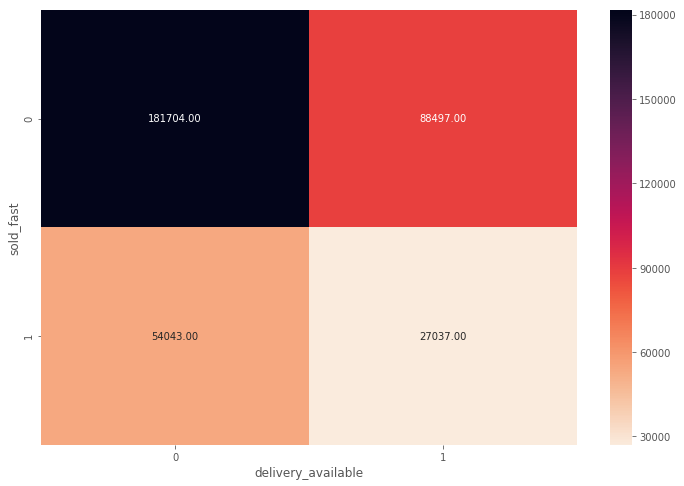

In [0]:
get_heatmap('delivery_available')

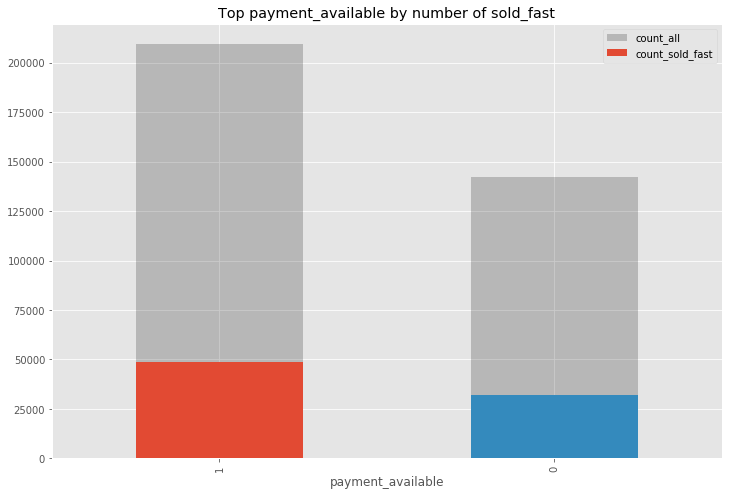

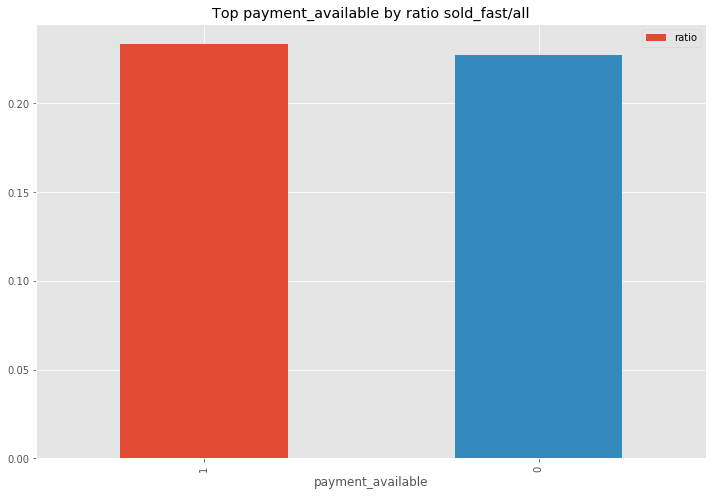

In [0]:
get_sold_fast('payment_available')

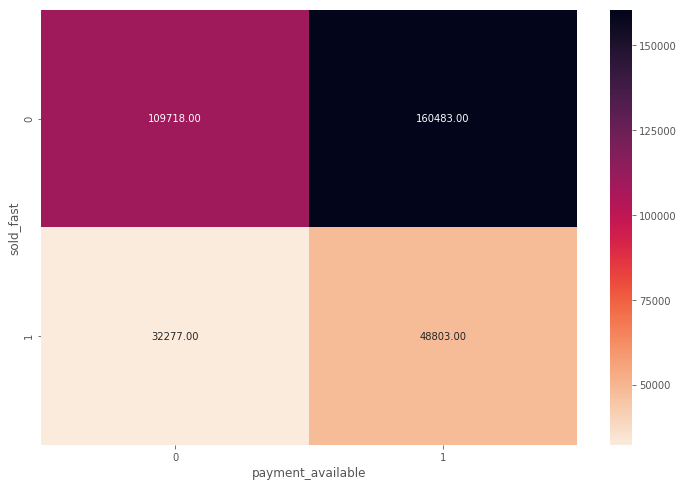

In [0]:
get_heatmap('payment_available')

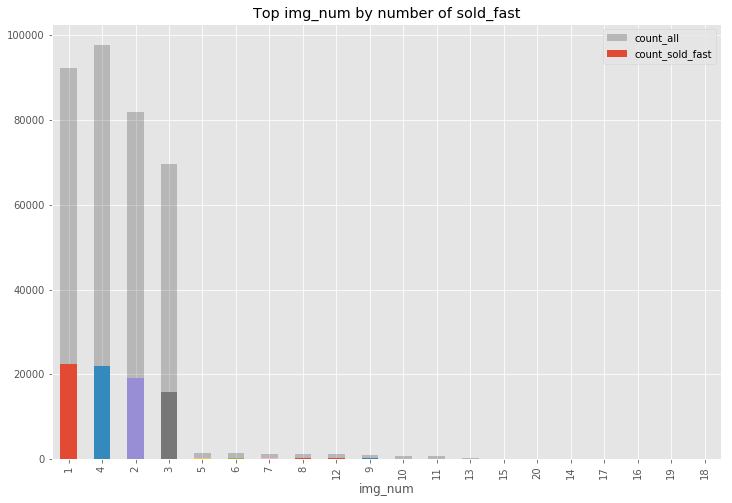

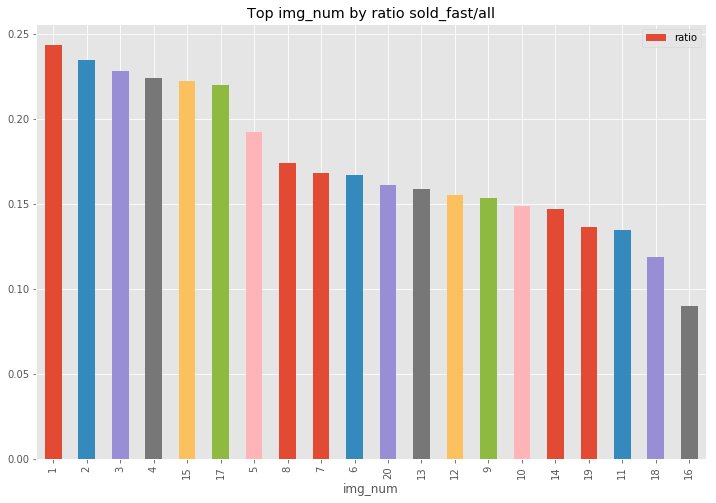

In [0]:
get_sold_fast('img_num')

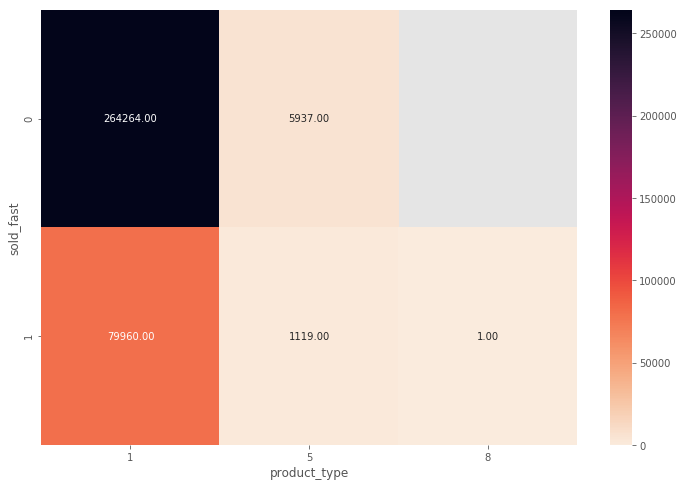

In [0]:
get_heatmap('product_type')

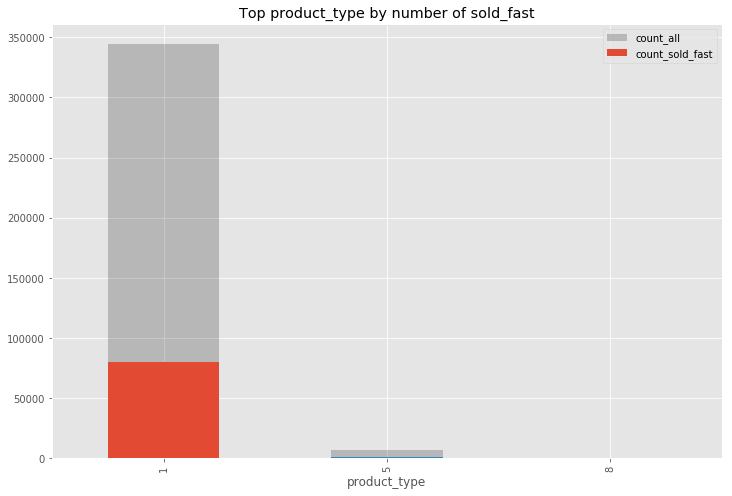

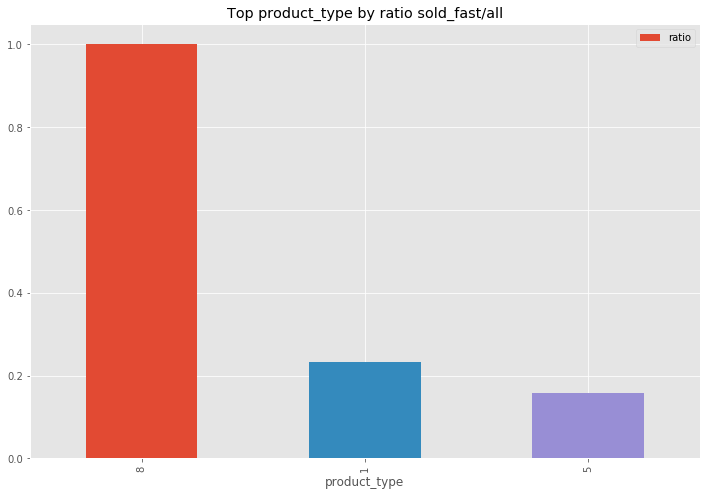

In [0]:
get_sold_fast('product_type')

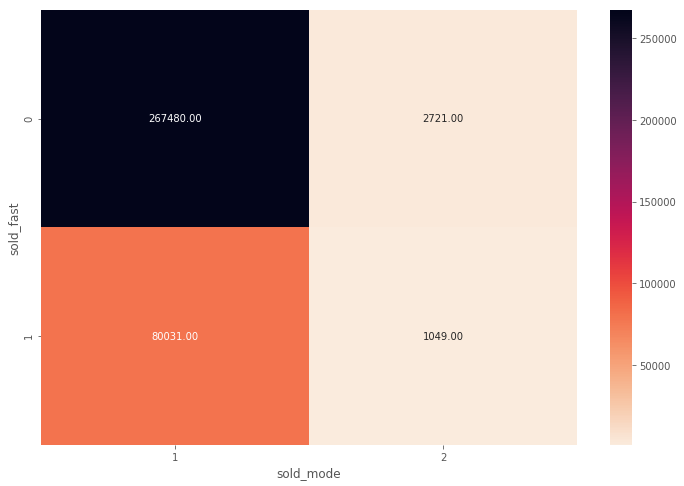

In [0]:
get_heatmap('sold_mode')

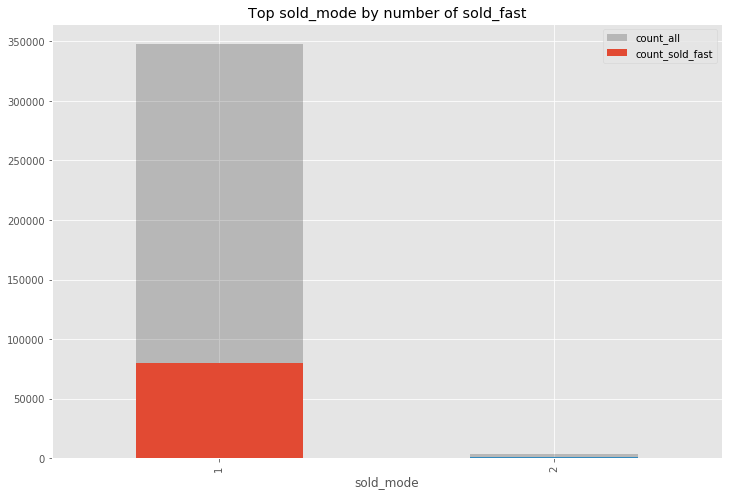

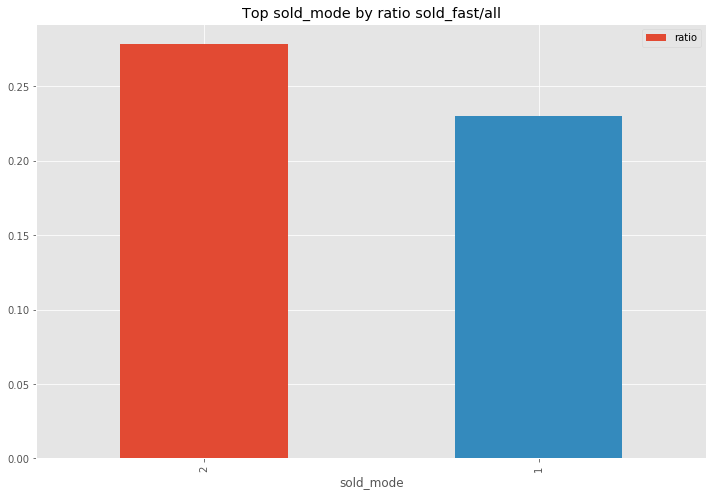

In [0]:
get_sold_fast('sold_mode')

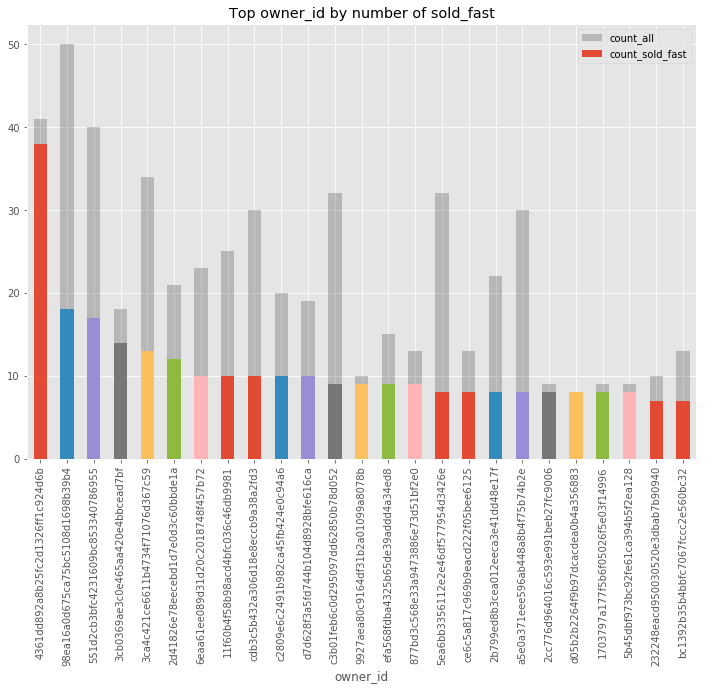

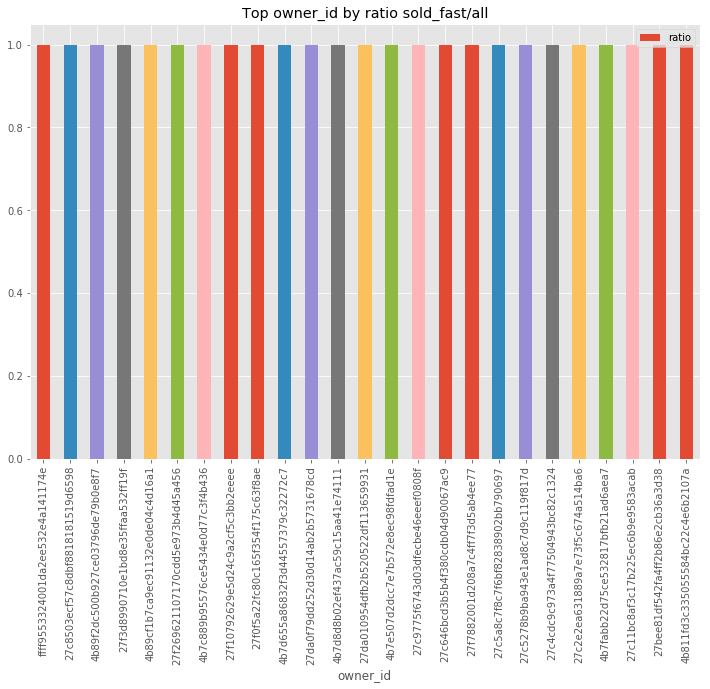

In [0]:
get_sold_fast('owner_id')

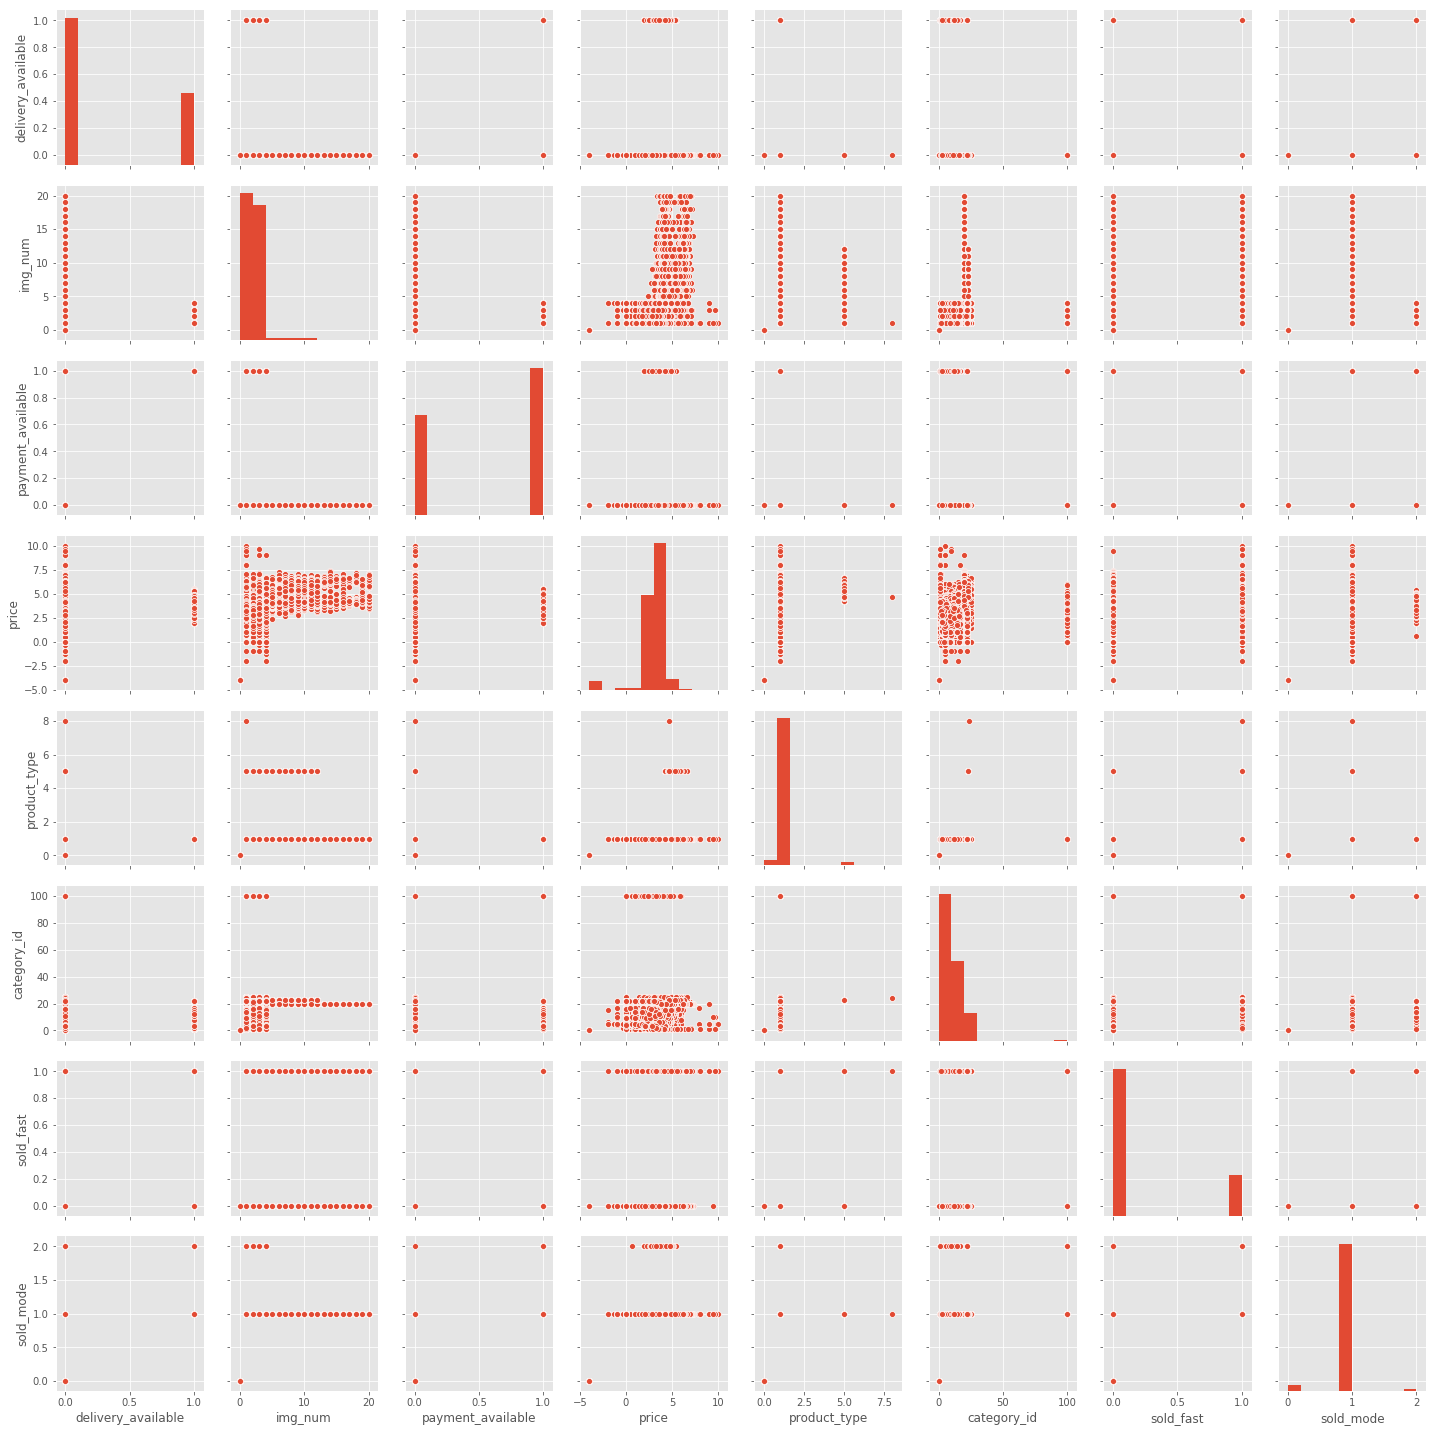

In [0]:
# много графиков
sns.pairplot(df2)

Work with date data


In [0]:
df.date_created.describe()

count                  351281
unique                    289
top       2018-03-25 00:00:00
freq                     1756
first     2018-01-01 00:00:00
last      2018-10-16 00:00:00
Name: date_created, dtype: object

In [0]:
# Add date info
df['day'] = df.date_created.apply(lambda x: x.day)
df['month'] = df.date_created.apply(lambda x: x.month)
df['weekday'] = df.date_created.apply(lambda x: x.isoweekday())

AttributeError: ignored

In [0]:
df.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast,day,month,weekday
1,4,Краснодар,2018-10-08,0,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,1,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,1,8,10,1
2,4,Тюмень,2018-06-18,0,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,0,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,0,18,6,1
4,9,Омск,2018-07-31,1,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,1,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,0,31,7,2
6,3,Санкт-Петербург,2018-04-17,0,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,1,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,0,17,4,2
10,5,Москва,2018-02-09,0,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,1,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0,9,2,5


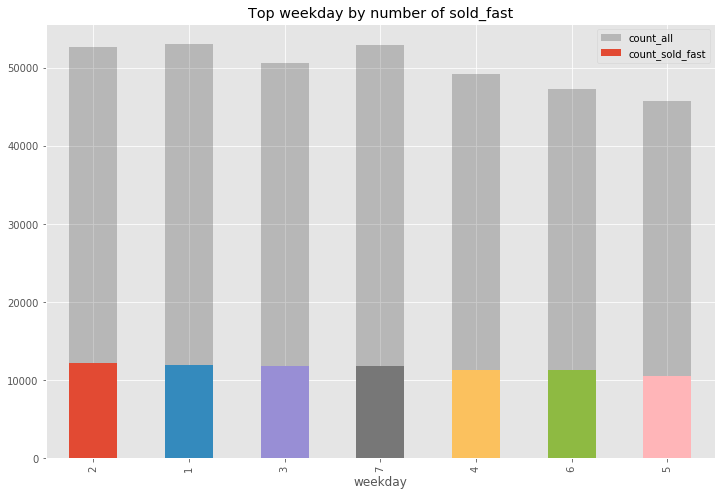

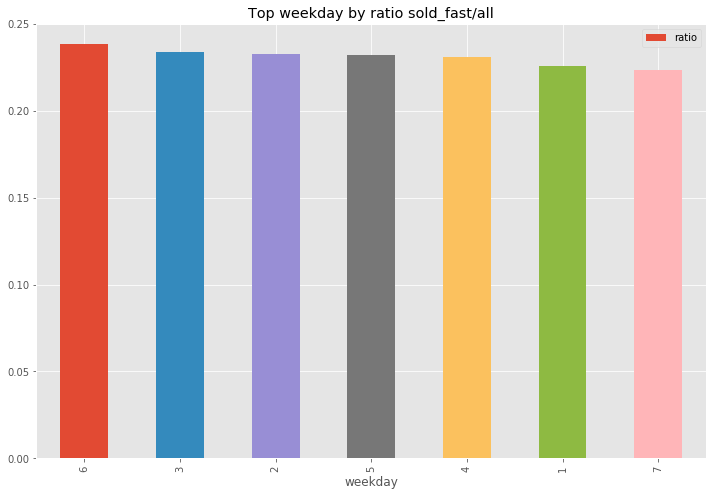

In [0]:
get_sold_fast('weekday')

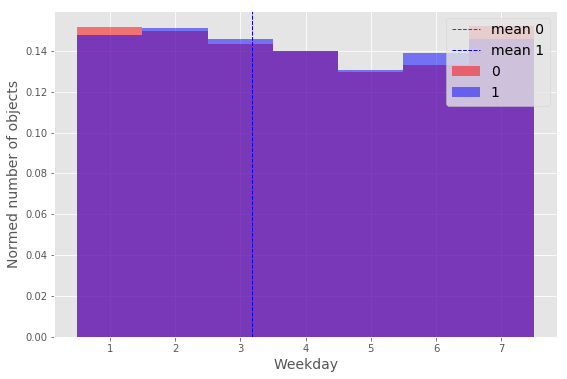

In [0]:
feature_values = df.weekday
labels = df.sold_fast.values

plt.figure(figsize=(9, 6))
bins = np.linspace(0.5, 7.5, 8)

plt.hist(feature_values[labels == 0], bins=bins, label='0', color='r', alpha=0.5, density=True)
plt.hist(feature_values[labels == 1], bins=bins, label='1', color='b', alpha=0.5, density=True)
plt.axvline(feature_values_notnull[labels_notnull == 1].mean(), color='r', linestyle='dashed', linewidth=1,label='mean 0')
plt.axvline(feature_values_notnull[labels_notnull == 0].mean(), color='b', linestyle='dashed', linewidth=1,label='mean 1')

plt.ylabel('Normed number of objects', size=14)
plt.xlabel('Weekday', size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

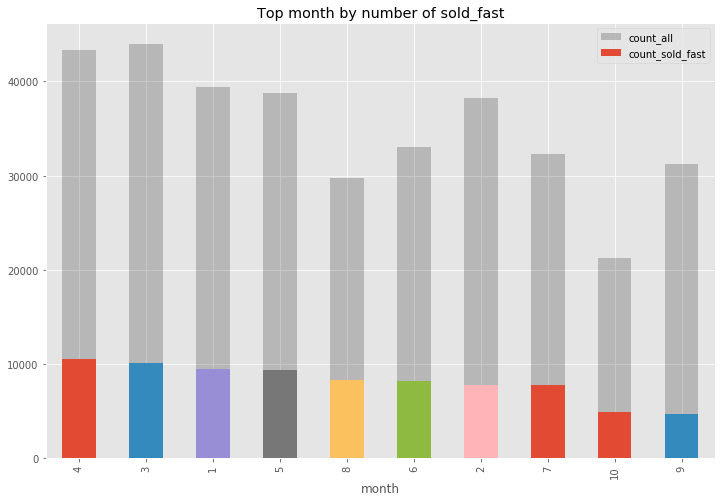

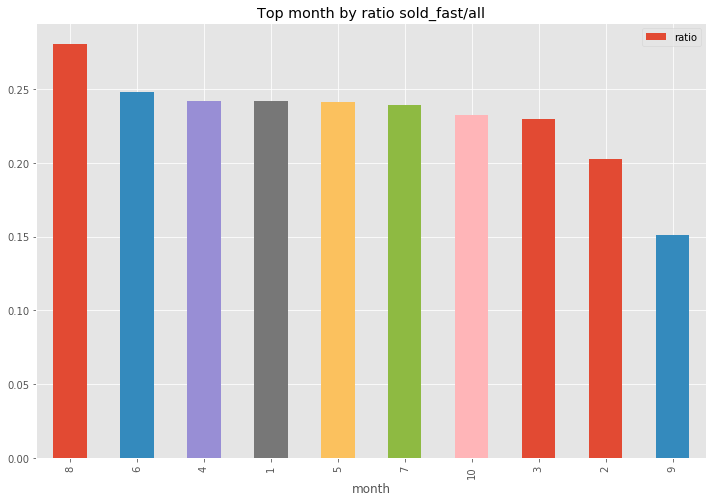

In [0]:
get_sold_fast('month')

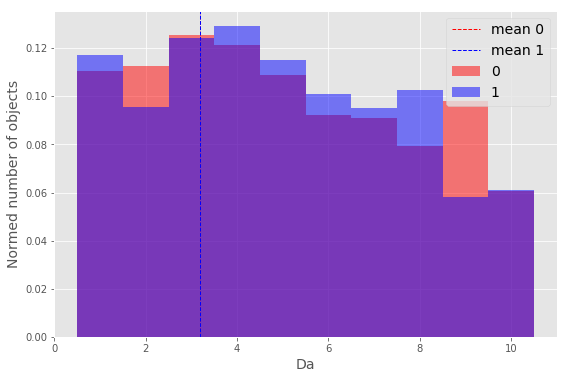

In [0]:
feature_values = df.month
labels = df.sold_fast.values

plt.figure(figsize=(9, 6))
bins = np.linspace(0.5, 10.5, 11)

plt.hist(feature_values[labels == 0], bins=bins, label='0', color='r', alpha=0.5, density=True)
plt.hist(feature_values[labels == 1], bins=bins, label='1', color='b', alpha=0.5, density=True)
plt.axvline(feature_values_notnull[labels_notnull == 1].mean(), color='r', linestyle='dashed', linewidth=1,label='mean 0')
plt.axvline(feature_values_notnull[labels_notnull == 0].mean(), color='b', linestyle='dashed', linewidth=1,label='mean 1')

plt.ylabel('Normed number of objects', size=14)
plt.xlabel('Da', size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

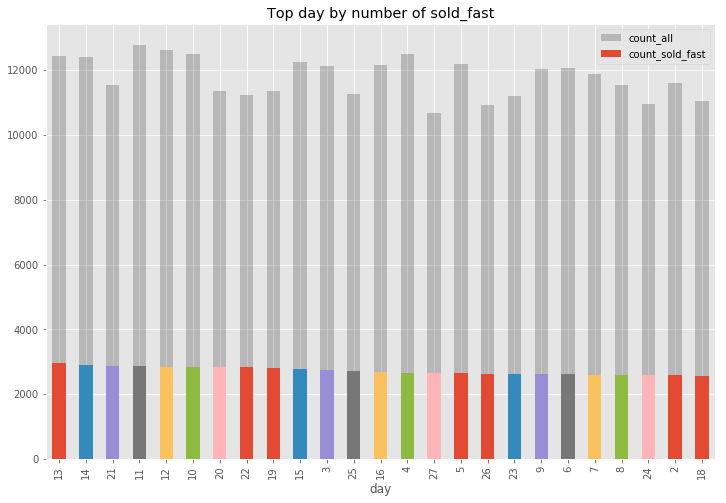

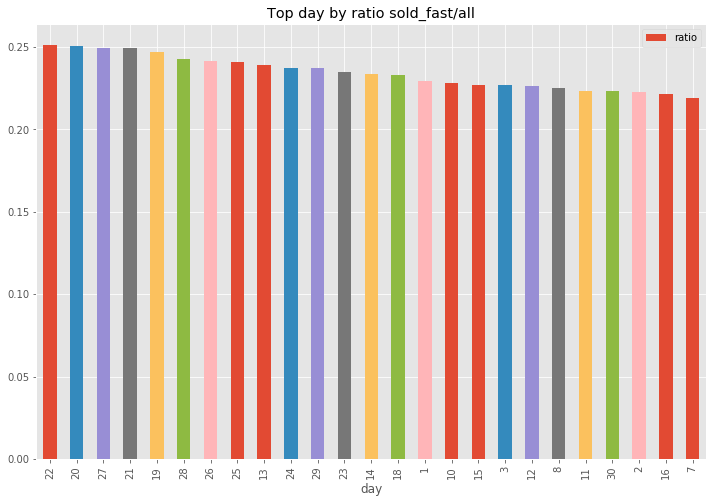

In [0]:
get_sold_fast('day')

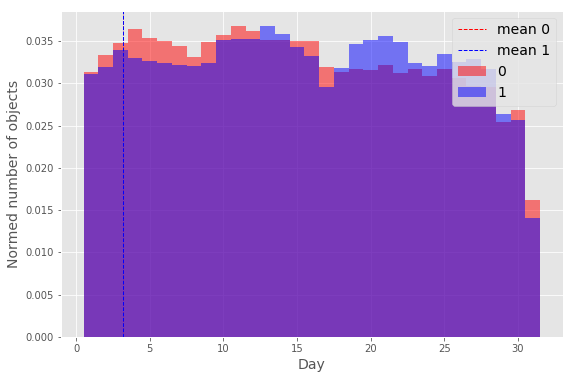

In [0]:
feature_values = df.day
labels = df.sold_fast.values

plt.figure(figsize=(9, 6))
bins = np.linspace(0.5, 31.5, 32)

plt.hist(feature_values[labels == 0], bins=bins, label='0', color='r', alpha=0.5, density=True)
plt.hist(feature_values[labels == 1], bins=bins, label='1', color='b', alpha=0.5, density=True)
plt.axvline(feature_values_notnull[labels_notnull == 1].mean(), color='r', linestyle='dashed', linewidth=1,label='mean 0')
plt.axvline(feature_values_notnull[labels_notnull == 0].mean(), color='b', linestyle='dashed', linewidth=1,label='mean 1')

plt.ylabel('Normed number of objects', size=14)
plt.xlabel('Day', size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

# (almost) Zero-knowledge prediction
* Develop non-machine learning approach to get predictions
    * Describe it and measure its quality on Kaggle

**По идее.**

- чем страннее описание, тем хуже
- чем больше картинок, тем лучше
- чем дешевле, тем лучше
- категория\суб? - это важно


- покупают активнее разные вещи в разные сезоны
- если это авито, то люди наверно мало смотрят на то, как много всего выставляет продавец, но если нет, то может наоборот
- выставленное в пределах суток или около того(ну или видимо 3х дней, раз такова задача) покупают лучше, чем всякое древнее
- цена должна быть связана с категорией\суб?


- есть ходовые категории товаров, типа телефонов(?)

**Шо видим**
- число картинок зависит от категории
- категория вполне дружит с субкатегорией 
- большая часть категорий одного product type, что бы это ни было
- категории обычно имеют маленькие номера, но небольшая часть - очень большие, что неудобно
- в некоторых местах(long,lat) всегда делают в среднем меньше картинок
- кажется цена связана с категорией и субкатегорией

# Machine-learning pipeline and prediction

Here you develop your pipeline, generate features for train and test sets
* Your pipeline should be reproducible - make sure you set all `random_states` if needed

In [0]:
# Split data
y_train = df.sold_fast.values
X_train = df.loc[:,df.columns != 'sold_fast']
X_train, X_test, y_train, y_test  = train_test_split(X_train,y_train,test_size=0.25,random_state=42)
X_val, X_test, y_val, y_test  = train_test_split(X_test,y_test,test_size=0.25,random_state=42)

In [0]:
features = ['category_id', 'city', 'date_created', 'delivery_available',
        'img_num', 'owner_id','payment_available', 'price', 'product_type',
        'region', 'sold_mode', 'subcategory_id']

In [0]:
features = ['sold_mode','day','month','weekday']
rf = RandomForestClassifier()
rf.fit(X_train[features],y_train)
cross_val_score(rf,X_val[features],y_val,cv=3,scoring='r2') 

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([-0.30230942, -0.30333912, -0.30050745])

In [0]:
pred = rf.predict(X_val[features])
print('roc_auc:',roc_auc_score(y_val, pred), 'recall_score:', recall_score(y_val, pred))
conf = pd.DataFrame(confusion_matrix(y_val,pred))
conf
#sns.heatmap(conf,annot=True)

roc_auc: 0.5003357693529747 recall_score: 0.0013219644391565867


,0,1
0,50703,33
1,15109,20


Text(0.5, 0, 'FPR')

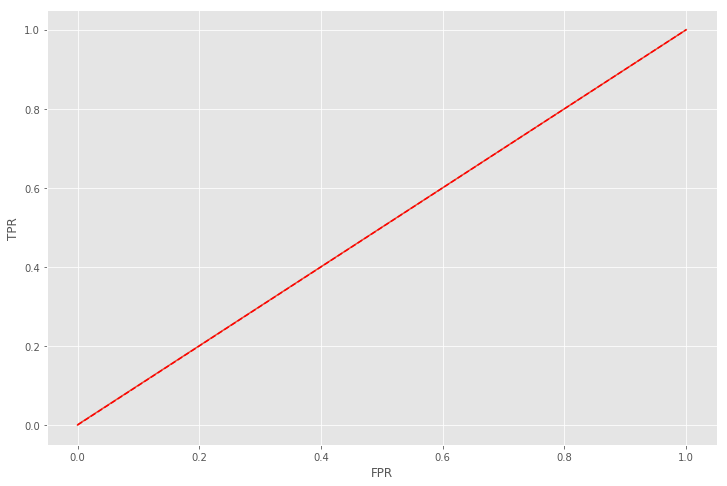

In [0]:
fpr, tpr, tresholds = roc_curve(y_val, pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')

Text(0.5, 0, 'Recall')

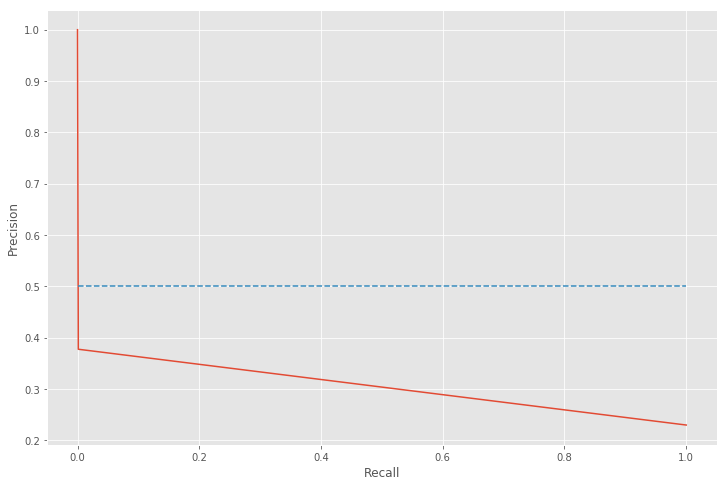

In [0]:
precision, recall, thresholds = precision_recall_curve(y_val, pred)
plt.plot(recall,precision)
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.ylabel('Precision')
plt.xlabel('Recall')

# Model interpretation
Try to interpret your model results
* What **knowledge** does it reveal?